# **Практическая работа №6. Проектирование автоэнкодеров для решения прикладных задач**

[**Ссылка на код с пары**](https://colab.research.google.com/drive/1KfCEQly5k0PUdCR1w-my2-QmYfFexdvK?usp=sharing)

# Задание №1. Реализуйте автоэнкодер для колоризации чёрно-белых изображений

* **Чем больше объектов разных классов будет в исходном датасете, тем универсальнее будет работа обученной Вами модели**

> Например, если в Вашем датасете только кошки, то все объекты кроме кошек будут колоризоваться некорректно. Соответственно следует очень тщательно подойти к выбору датасета. 

  * Для решения данной задачи может подойти датасет [CIFAR-100](https://www.kaggle.com/datasets/fedesoriano/cifar100), но его минус заключается в том, что разрешение изображений довольно низкое

* Хорошим вариантом будет использование датасета [ImageNet](https://paperswithcode.com/dataset/imagenet), но ввиду его объёмности, процесс обучения займет большое количество времени, поэтому Вы можете использовать одну из его [сокращенных версий](https://www.kaggle.com/datasets/ifigotin/imagenetmini-1000)

 **Конечный выбор датасета осуществляется по Вашему желанию, учитывая рекомендации приведенные выше.**


In [106]:
from tensorflow import keras
from keras.layers import Conv2D, UpSampling2D, Input, Conv2DTranspose
from keras.models import Sequential, Model
from keras.preprocessing.image import ImageDataGenerator
from keras.utils import img_to_array, load_img
from skimage.color import rgb2lab, lab2rgb, gray2rgb, rgb2gray
from skimage.transform import resize
from skimage.io import imsave
from matplotlib import pyplot as plt
from keras.preprocessing.image import ImageDataGenerator
import numpy as np
import tensorflow as tf
import keras
import cv2
import os
from keras.optimizers import Adam

In [107]:
# В качестве энкодера используем предобученную модель VGG19
from keras.applications.vgg19 import VGG19
# Импортируем предобученную модель VGG19, оставляя только слои, используемые для извлечения признаков
encoder_model = VGG19(include_top=False, input_shape=(224, 224, 3))

encoder_model.trainable = False

encoder_model.summary()


Model: "vgg19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_22 (InputLayer)       [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [108]:
autoencoder_model = Sequential()
autoencoder_model.add(encoder_model)
autoencoder_model.add(Conv2D(256, (3, 3), activation='relu', padding='same'))
autoencoder_model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
autoencoder_model.add(UpSampling2D((2, 2)))
autoencoder_model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
autoencoder_model.add(UpSampling2D((2, 2)))
autoencoder_model.add(Conv2D(32, (3, 3), activation='relu', padding='same'))
autoencoder_model.add(UpSampling2D((2, 2)))
autoencoder_model.add(Conv2D(16, (3, 3), activation='relu', padding='same'))
autoencoder_model.add(UpSampling2D((2, 2)))
autoencoder_model.add(Conv2D(2, (3, 3), activation='tanh', padding='same'))
autoencoder_model.add(UpSampling2D((2, 2)))
autoencoder_model.summary()

autoencoder_model.compile(optimizer=Adam(learning_rate=0.0001), loss='mse', metrics=['accuracy'])


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg19 (Functional)          (None, 7, 7, 512)         20024384  
                                                                 
 conv2d_127 (Conv2D)         (None, 7, 7, 256)         1179904   
                                                                 
 conv2d_128 (Conv2D)         (None, 7, 7, 128)         295040    
                                                                 
 up_sampling2d_60 (UpSamplin  (None, 14, 14, 128)      0         
 g2D)                                                            
                                                                 
 conv2d_129 (Conv2D)         (None, 14, 14, 64)        73792     
                                                                 
 up_sampling2d_61 (UpSamplin  (None, 28, 28, 64)       0         
 g2D)                                                 

In [109]:
seed = 24
batch_size = 64

In [110]:
def prepocess_image(image):
        lab = rgb2lab(image)
        x = gray2rgb(lab[:,:,0])
        x = keras.applications.vgg19.preprocess_input(x)
        y = lab[:,:,1:] / 128
        return (x, y)

In [111]:
from concurrent.futures import ThreadPoolExecutor, as_completed

def preprocess_data(images):
    max_workers = 20
    X = []
    Y = []
    with ThreadPoolExecutor(max_workers=max_workers) as executor:
        futures = []
        for image in images:
            future = executor.submit(prepocess_image, image)
            futures.append(future)
        

        for future in as_completed(futures):
            x, y = future.result()
            X.append(x)
            Y.append(y)

    X = np.asarray(X)
    Y = np.asarray(Y)

    return (X, Y)

In [112]:
def get_filenames(path):
    img_data_gen_args = dict(horizontal_flip=False,
                             vertical_flip=False)
    image_datagen = ImageDataGenerator(**img_data_gen_args)

    image_generator = image_datagen.flow_from_directory(
        path,
        class_mode=None,
        target_size=(224, 224),
        batch_size=batch_size,
        seed=seed)
    return image_generator.filenames


In [113]:
def trainGenerator(train_img_path):

    img_data_gen_args = dict(horizontal_flip=False,
                             vertical_flip=False)

    image_datagen = ImageDataGenerator(**img_data_gen_args)

    image_generator = image_datagen.flow_from_directory(
        train_img_path,
        class_mode=None,
        target_size=(224, 224),
        batch_size=batch_size,
        seed=seed)

    for img in image_generator:
        gray, orig = preprocess_data(img)
        yield (gray, orig)


In [114]:
train_img_path = r'.\data\colorize\train'
train_img_gen = trainGenerator(train_img_path)

val_img_path = r'.\data\colorize\val'
val_img_gen = trainGenerator(val_img_path)

In [115]:
filenames = get_filenames(train_img_path)
steps_per_epoch_train = len(filenames) // batch_size


Found 2048 images belonging to 1 classes.


In [116]:
filenames = get_filenames(val_img_path)
steps_per_epoch_val = len(filenames) // batch_size


Found 256 images belonging to 1 classes.


In [117]:
history = autoencoder_model.fit(
    train_img_gen,
    steps_per_epoch=steps_per_epoch_train,
    validation_steps=steps_per_epoch_val,
    batch_size=batch_size,
    epochs=20,
    verbose=1,
    validation_data=val_img_gen
    )


Found 2048 images belonging to 1 classes.


KeyboardInterrupt: 

In [ ]:
autoencoder_model.save('.\models\colorize_autoencoder_VGG19.h5')

In [ ]:
def predict(imagePath):
    orig = img_to_array(load_img(imagePath))
    test = orig.copy()
    test = resize(test, (224,224), anti_aliasing=True)
    test *= 1.0/255
    lab = rgb2lab(test)
    l = lab[:,:,0]
    L = gray2rgb(l)
    L = L.reshape((1,224,224,3))
    L = keras.applications.vgg19.preprocess_input(L)
    ab = autoencoder_model.predict(L)

    ab = ab*128
    cur = np.zeros((224, 224, 3))
    cur[:,:,0] = l
    cur[:,:,1:] = ab
    
    rgb = cv2.cvtColor(cur.astype('uint8'), cv2.COLOR_LAB2RGB)
    plt.figure(figsize=(10, 5))

    orig_plt = plt.subplot(1, 3, 1)
    orig_plt.imshow(orig.astype("uint8"))
    orig_plt.set_title("original")
    orig_plt.axis("off")

    gray_plt = plt.subplot(1, 3, 2)
    gray_plt.set_title("GRAY")
    gray_plt.axis("off")
    gray_plt.imshow(l.astype("uint8"), cmap=plt.cm.gray)

    rgb_plt = plt.subplot(1, 3, 3)
    rgb_plt.imshow(rgb.astype("uint8"))
    rgb_plt.set_title("RGB recovered")
    rgb_plt.axis("off")

1/1 [==============================] - 0s 16ms/step


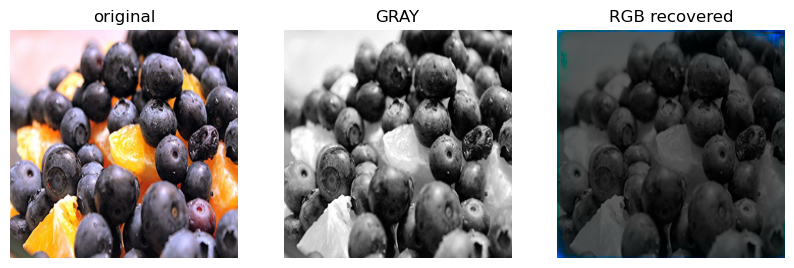

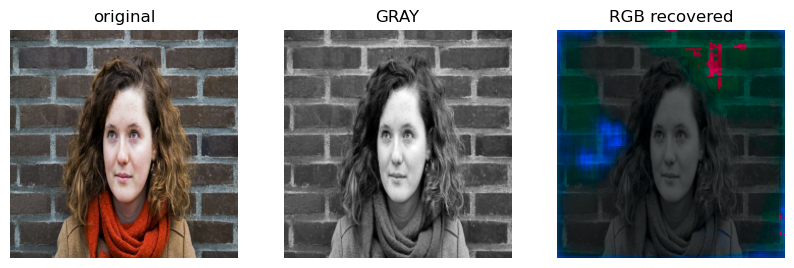

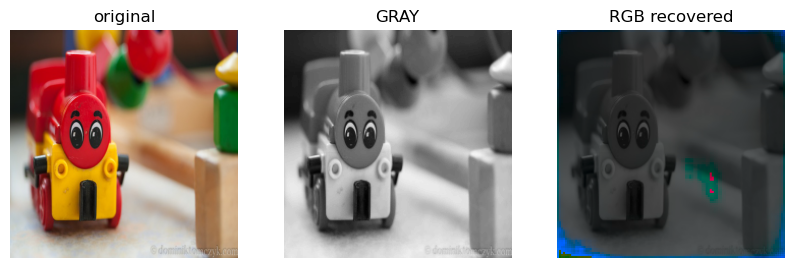

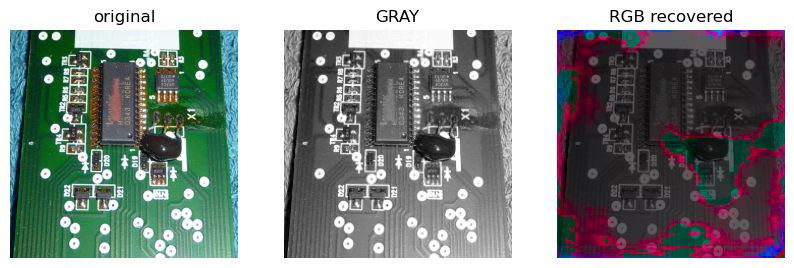

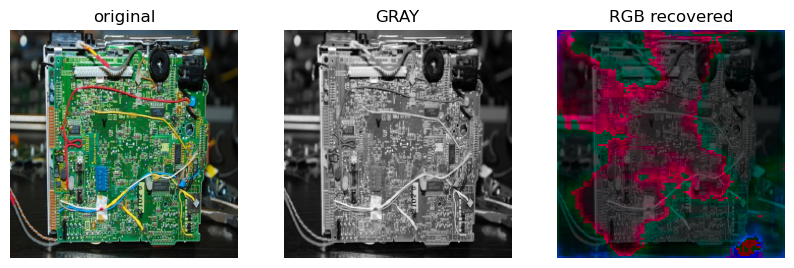

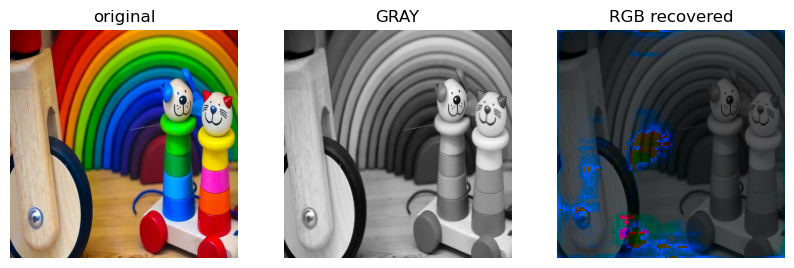

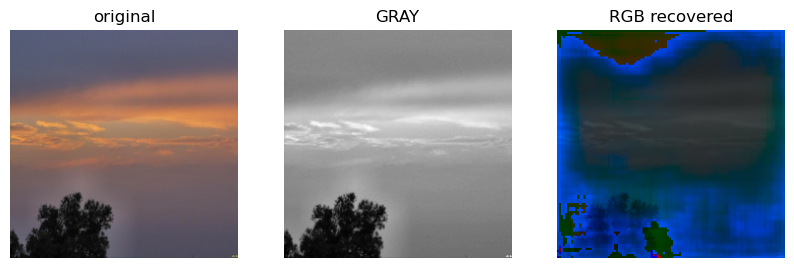

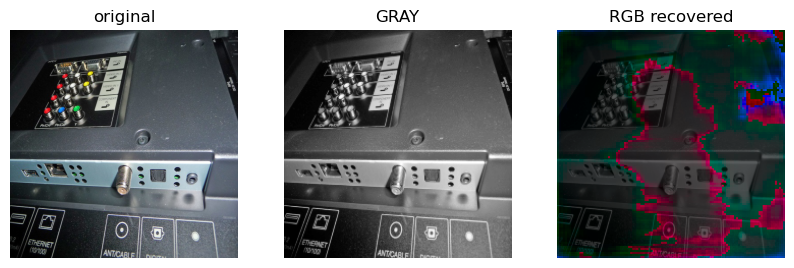

In [ ]:
from imutils import paths
imagePaths = sorted(list(paths.list_images(r".\data\colorize\test\images")))
for imagePath in imagePaths:
    predict(imagePath)

# Задание №2. Реализуйте автоэнкодер для удаления шума на однотипных изображениях

1.  Подберите датасет, состоящий из однотипных изображений, которые в реальной жизни часто подвержены зашумлению, например спутниковые снимки, ночные фотографии и т.д.

2.  Затем примените к ним операцию зашумления и обучите модель. Также учитывайте тип шума, который Вы применяете. Он должен быть приближен к естественному.

Хороший пример реализации подобной задачи: https://www.kaggle.com/code/michalbrezk/denoise-images-using-autoencoders-tf-keras
Датасет фото с шумом и без https://www.eecs.yorku.ca/~kamel/sidd/dataset.php

In [ ]:
import matplotlib.pyplot as plt
from tensorflow import keras
import cv2
import numpy as np
from keras import layers
from keras.layers import Dense, Flatten
from keras.models import Sequential, Model
from keras.optimizers import Adam
from imutils import paths
from keras.preprocessing.image import ImageDataGenerator


In [ ]:
input = layers.Input(shape=(220, 220, 3)) 

e_conv1 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(input)
pool1 = layers.MaxPooling2D((2, 2), padding='same')(e_conv1)
batchnorm_1 = layers.BatchNormalization()(pool1)

e_conv2 = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(batchnorm_1)
pool2 = layers.MaxPooling2D((2, 2), padding='same')(e_conv2)
batchnorm_2 = layers.BatchNormalization()(pool2)

e_conv3 = layers.Conv2D(16, (3, 3), activation='relu', padding='same')(batchnorm_2)
h = layers.MaxPooling2D((2, 2), padding='same')(e_conv3)

d_conv1 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(h)
up1 = layers.UpSampling2D((2, 2))(d_conv1)

d_conv2 = Conv2D(32, (3, 3), activation='relu', padding='same')(up1)
up2 = layers.UpSampling2D((2, 2))(d_conv2)

d_conv3 = layers.Conv2D(16, (3, 3), activation='relu')(up2)
up3 = layers.UpSampling2D((2, 2))(d_conv3)
    
r = Conv2D(3, (3, 3), activation='sigmoid', padding='same')(up3)

autoencoder = Model(input, r)
autoencoder.compile(optimizer=Adam(learning_rate=0.0005), loss='mse')
autoencoder.summary()

Model: "model_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_8 (InputLayer)        [(None, 220, 220, 3)]     0         
                                                                 
 conv2d_39 (Conv2D)          (None, 220, 220, 64)      1792      
                                                                 
 max_pooling2d_18 (MaxPoolin  (None, 110, 110, 64)     0         
 g2D)                                                            
                                                                 
 batch_normalization_6 (Batc  (None, 110, 110, 64)     256       
 hNormalization)                                                 
                                                                 
 conv2d_40 (Conv2D)          (None, 110, 110, 32)      18464     
                                                                 
 max_pooling2d_19 (MaxPoolin  (None, 55, 55, 32)       0   

In [ ]:
seed = 24
batch_size = 64

In [ ]:
def preprocess_data(img, watermark):
    img = img.astype("float32") / 255.0
    watermark = watermark.astype("float32") / 255.0
    img = np.reshape(img, (len(img), 220, 220, 3))
    watermark = np.reshape(watermark, (len(watermark), 220, 220, 3))
      
    return (img, watermark)

In [ ]:
def trainGenerator(train_img_path, watermark_img_path):

    img_data_gen_args = dict(horizontal_flip=False,
                             vertical_flip=False)

    image_datagen = ImageDataGenerator(**img_data_gen_args)

    image_generator = image_datagen.flow_from_directory(
        train_img_path,
        class_mode=None,
        target_size=(220, 220),
        batch_size=batch_size,
        seed=seed)
    
    watermark_generator = image_datagen.flow_from_directory(
        watermark_img_path,
        class_mode=None,
        target_size=(220, 220),
        batch_size=batch_size,
        seed=seed)

    train_generator = zip(image_generator, watermark_generator)
    
    for (img, watermark) in train_generator:
        img, watermark = preprocess_data(img, watermark)
        yield (img, watermark)

In [ ]:
def get_filenames(path):
    img_data_gen_args = dict(horizontal_flip=False,
                             vertical_flip=False)
    image_datagen = ImageDataGenerator(**img_data_gen_args)

    image_generator = image_datagen.flow_from_directory(
        path,
        class_mode=None,
        target_size=(220, 220),
        batch_size=batch_size,
        seed=seed)
    return image_generator.filenames

In [ ]:
train_img_path = r'.\data\denoise\train\gt'
watermark_img_path = r'.\data\denoise\train\watermark'
train_img_gen = trainGenerator(train_img_path, watermark_img_path)

valid_img_path = r'.\data\denoise\valid\gt'
valid_watermark_img_path = r'.\data\denoise\valid\watermark'
valid_img_gen = trainGenerator(valid_img_path, valid_watermark_img_path)

In [ ]:
filenames = get_filenames(train_img_path)
steps_per_epoch_train = len(filenames) // batch_size

Found 2100 images belonging to 1 classes.


In [ ]:
filenames = get_filenames(valid_img_path)
steps_per_epoch_val = len(filenames) // batch_size

Found 256 images belonging to 1 classes.


In [ ]:
history = autoencoder.fit(
    train_img_gen,
    steps_per_epoch=steps_per_epoch_train,
    batch_size=batch_size,
    epochs=30,
    verbose=1,
    validation_steps=steps_per_epoch_val,
    validation_data=valid_img_gen
    )

Epoch 1/30
32/32 [==============================] - 14s 453ms/step - loss: 0.0156 - val_loss: 0.0160
Epoch 2/30
32/32 [==============================] - 14s 447ms/step - loss: 0.0155 - val_loss: 0.0151
Epoch 3/30
32/32 [==============================] - 14s 445ms/step - loss: 0.0154 - val_loss: 0.0157
Epoch 4/30
32/32 [==============================] - 14s 443ms/step - loss: 0.0156 - val_loss: 0.0160
Epoch 5/30
32/32 [==============================] - 14s 446ms/step - loss: 0.0160 - val_loss: 0.0157
Epoch 6/30
32/32 [==============================] - 14s 451ms/step - loss: 0.0160 - val_loss: 0.0157
Epoch 7/30
32/32 [==============================] - 14s 454ms/step - loss: 0.0156 - val_loss: 0.0156
Epoch 8/30
32/32 [==============================] - 14s 450ms/step - loss: 0.0153 - val_loss: 0.0162
Epoch 9/30
32/32 [==============================] - 14s 435ms/step - loss: 0.0154 - val_loss: 0.0156
Epoch 10/30
32/32 [==============================] - 14s 447ms/step - loss: 0.0153 - val_lo

In [ ]:
def predict(imagePath):
    orig = img_to_array(load_img(imagePath))
    test = orig.copy()
    test = resize(test, (220,220), anti_aliasing=True)
    test *= 1.0/255
    test = test.reshape((1,220,220,3))
    pred = autoencoder.predict(test)

    pred = pred[0]*256

    plt.figure(figsize=(10, 5))

    orig_plt = plt.subplot(1, 2, 1)
    orig_plt.set_title("Waterarked")
    orig_plt.axis("off")
    orig_plt.imshow(orig.astype("uint8"))

    clean_plt = plt.subplot(1, 2, 2)
    clean_plt.set_title("Cleaned")
    clean_plt.axis("off")
    clean_plt.imshow(pred.astype("uint8"))


1/1 [==============================] - 0s 16ms/step


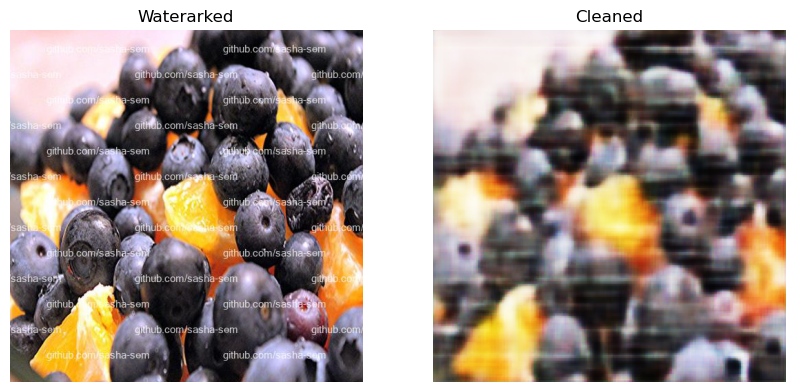

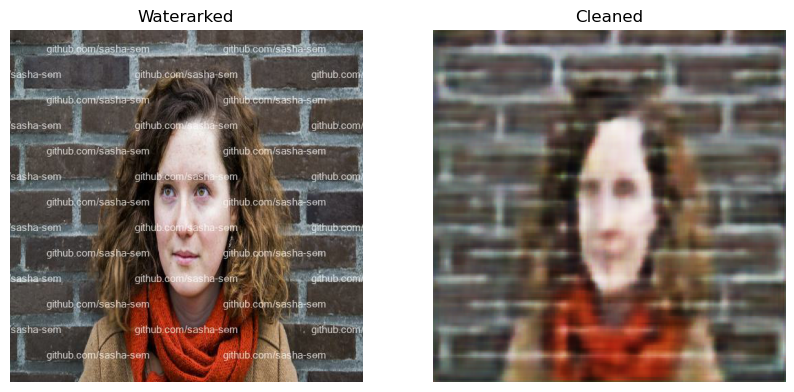

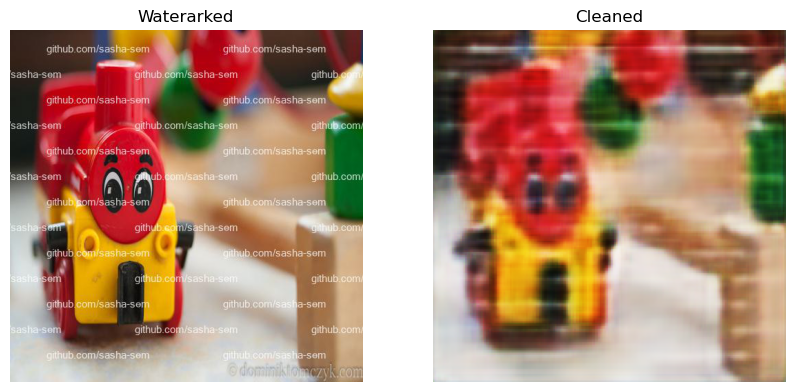

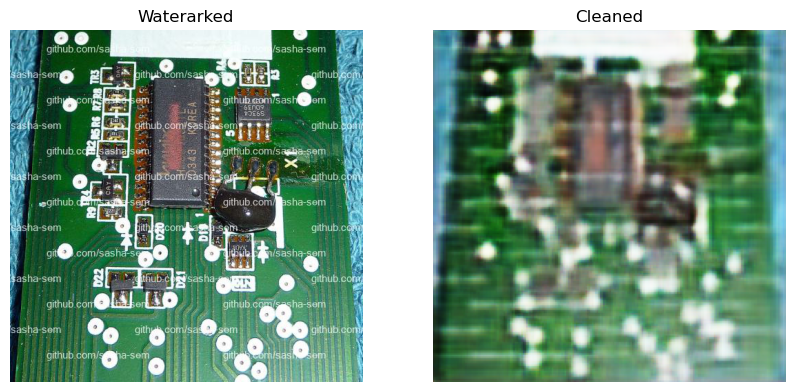

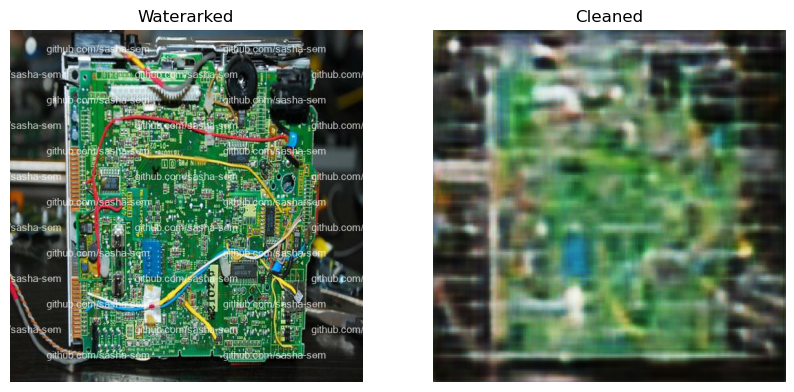

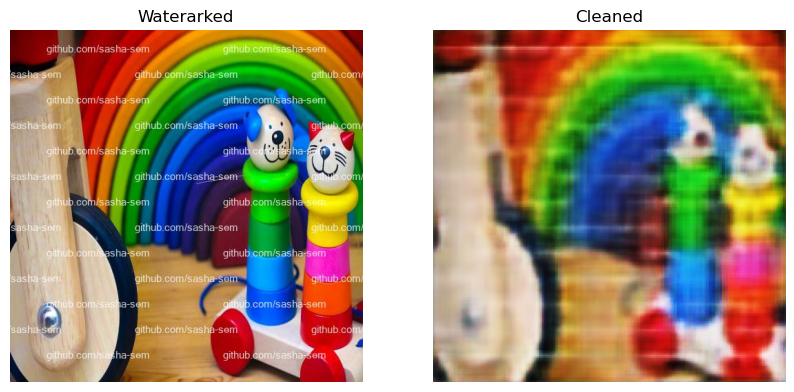

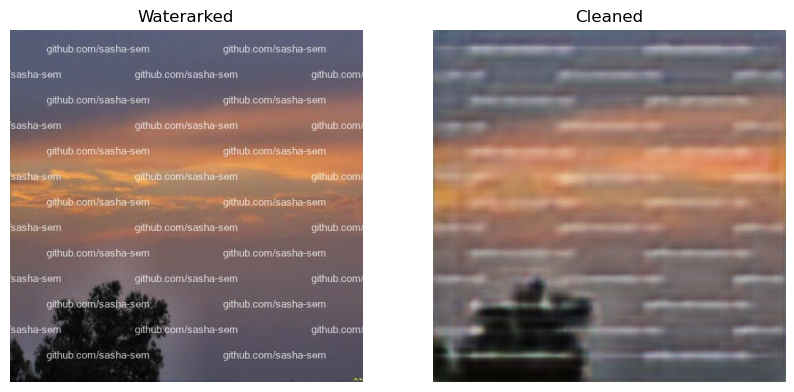

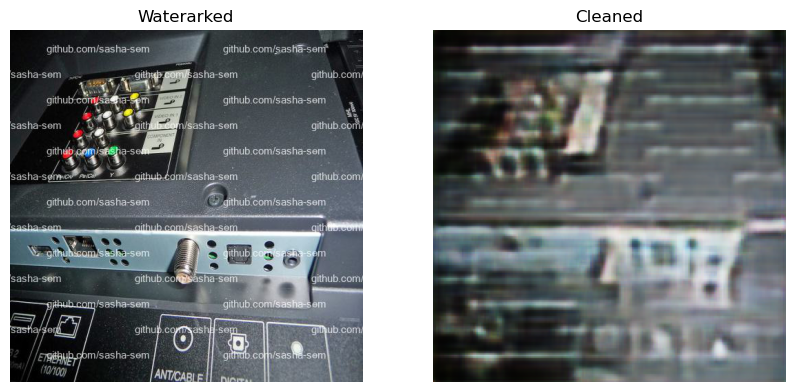

In [ ]:
from imutils import paths
imagePaths = sorted(list(paths.list_images(r".\data\denoise\test\images")))
for imagePath in imagePaths:
    predict(imagePath)

# Задание №.3 Реализуйте автоэнкодер для улучшения качества изображения путём увеличения его разрешения (апскейлинг-[определение](https://dic.academic.ru/dic.nsf/ruwiki/346555))

1. На входной слой нейронной сети подаётся изображение с размерностью (256, 256,3) - X_test. В результате работы нейронной сети на выходном слое должно получиться изображение (512, 512, 3) - Y_test. В итоге мы получаем двукратный апскейл исходного изображения.

2. Датасет собираете из изображений, разрешение которых выше эталонного (512,512,3). Затем преобразуете их в указанные размерности и формируете из них обучающую и проверочную выборку. 

3. Обучите модель. Отобразите графики обучения

4. Подумайте, каким образом можно будет адаптировать модель вашей нейронной сети для двухратного апскейла изображения с любой размерностью, большей, чем (256,256,3), с полным или частичным сохранением его исходных пропорций. Например: подаём на вход изображение с разрешением (1920, 1080, 3) - получаем изображение с разрешением (3840, 2160, 3), т.е. с полным сохранением исходных пропорций или (1792, 1024, 3) с частичным сохранением исходных пропорций.

> Подсказка: Для этого можно реализовать алгоритм предварительной обработки исходного изображения, перед подачей его в нейронную сеть

In [129]:
import matplotlib.pyplot as plt
from tensorflow import keras
import cv2
import numpy as np
from keras import layers
from keras.layers import Dense, Flatten
from keras.models import Sequential, Model
from keras.optimizers import Adam
from imutils import paths
from keras.preprocessing.image import ImageDataGenerator


In [130]:
input = layers.Input(shape=(256, 256, 3)) 

e_conv1 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(input)
pool1 = layers.MaxPooling2D((2, 2), padding='same')(e_conv1)
batchnorm_1 = layers.BatchNormalization()(pool1)

e_conv2 = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(batchnorm_1)
pool2 = layers.MaxPooling2D((2, 2), padding='same')(e_conv2)
batchnorm_2 = layers.BatchNormalization()(pool2)

e_conv3 = layers.Conv2D(16, (3, 3), activation='relu', padding='same')(batchnorm_2)
h = layers.MaxPooling2D((2, 2), padding='same')(e_conv3)

d_conv1 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(h)
up1 = layers.UpSampling2D((2, 2))(d_conv1)

d_conv2 = Conv2D(32, (3, 3), activation='relu', padding='same')(up1)
up2 = layers.UpSampling2D((2, 2))(d_conv2)

d_conv3 = Conv2DTranspose(16, (3, 3), activation='relu', padding='same')(up2)
up3 = layers.UpSampling2D((2, 2))(d_conv3)

d_conv4 = Conv2DTranspose(8, (3, 3), activation='relu', padding='same')(up3)
up4 = layers.UpSampling2D((2, 2))(d_conv4)

r = Conv2D(3, (3, 3), activation='sigmoid', padding='same')(up4)

autoencoder = Model(input, r)
autoencoder.compile(optimizer=Adam(learning_rate=0.0005), loss='mse')
autoencoder.summary()

Model: "model_21"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_25 (InputLayer)       [(None, 256, 256, 3)]     0         
                                                                 
 conv2d_145 (Conv2D)         (None, 256, 256, 64)      1792      
                                                                 
 max_pooling2d_66 (MaxPoolin  (None, 128, 128, 64)     0         
 g2D)                                                            
                                                                 
 batch_normalization_38 (Bat  (None, 128, 128, 64)     256       
 chNormalization)                                                
                                                                 
 conv2d_146 (Conv2D)         (None, 128, 128, 32)      18464     
                                                                 
 max_pooling2d_67 (MaxPoolin  (None, 64, 64, 32)       0  

In [131]:
seed = 24
batch_size = 64

In [132]:
def preprocess_data(img, hd_img):
    img = img.astype("float32") / 255.0
    hd_img = hd_img.astype("float32") / 255.0
    img = img.reshape(len(img), 256, 256, 3)
    hd_img = hd_img.reshape((len(hd_img), 512, 512, 3))
      
    return (img, hd_img)

In [133]:
def trainGenerator(train_img_path, hd_img_path):

    img_data_gen_args = dict(horizontal_flip=False,
                             vertical_flip=False)

    image_datagen = ImageDataGenerator(**img_data_gen_args)

    image_generator = image_datagen.flow_from_directory(
        train_img_path,
        class_mode=None,
        target_size=(256, 256),
        batch_size=batch_size,
        seed=seed)
    
    hd_img_generator = image_datagen.flow_from_directory(
        hd_img_path,
        class_mode=None,
        target_size=(512, 512),
        batch_size=batch_size,
        seed=seed)

    train_generator = zip(image_generator, hd_img_generator)
    
    for (img, hd_img) in train_generator:
        img, hd_img = preprocess_data(img, hd_img)
        yield (img, hd_img)

In [134]:
def get_filenames(path):
    img_data_gen_args = dict(horizontal_flip=False,
                             vertical_flip=False)
    image_datagen = ImageDataGenerator(**img_data_gen_args)

    image_generator = image_datagen.flow_from_directory(
        path,
        class_mode=None,
        target_size=(220, 220),
        batch_size=batch_size,
        seed=seed)
    return image_generator.filenames

In [135]:
train_img_path = r'.\data\upscale\train\low_res'
train_hd_img_path = r'.\data\upscale\train\high_res'
train_img_gen = trainGenerator(train_img_path, train_hd_img_path)

valid_img_path = r'.\data\upscale\valid\low_res'
valid_hd_img_path = r'.\data\upscale\valid\high_res'
valid_img_gen = trainGenerator(valid_img_path, valid_hd_img_path)

In [136]:
filenames = get_filenames(train_img_path)
steps_per_epoch_train = len(filenames) // batch_size

Found 2048 images belonging to 1 classes.


In [137]:
filenames = get_filenames(valid_img_path)
steps_per_epoch_val = len(filenames) // batch_size

Found 256 images belonging to 1 classes.


In [138]:
history = autoencoder.fit(
    train_img_gen,
    steps_per_epoch=steps_per_epoch_train,
    batch_size=batch_size,
    epochs=30,
    verbose=1,
    validation_steps=steps_per_epoch_val,
    validation_data=valid_img_gen
    )

Found 2048 images belonging to 1 classes.
Found 2048 images belonging to 1 classes.
Epoch 1/30
32/32 [==============================] - ETA: 0s - loss: 0.0496Found 256 images belonging to 1 classes.
Found 256 images belonging to 1 classes.
32/32 [==============================] - 34s 1s/step - loss: 0.0496 - val_loss: 0.0790
Epoch 2/30
32/32 [==============================] - 19s 602ms/step - loss: 0.0190 - val_loss: 0.0734
Epoch 3/30
32/32 [==============================] - 19s 599ms/step - loss: 0.0149 - val_loss: 0.0737
Epoch 4/30
32/32 [==============================] - 19s 595ms/step - loss: 0.0132 - val_loss: 0.0665
Epoch 5/30
32/32 [==============================] - 19s 596ms/step - loss: 0.0124 - val_loss: 0.0626
Epoch 6/30
32/32 [==============================] - 19s 600ms/step - loss: 0.0117 - val_loss: 0.0578
Epoch 7/30
32/32 [==============================] - 19s 604ms/step - loss: 0.0110 - val_loss: 0.0503
Epoch 8/30
32/32 [==============================] - 19s 612ms/step 

In [ ]:
def predict(imagePath):
    orig = img_to_array(load_img(imagePath))
    test = orig.copy()
    test = resize(test, (256,256), anti_aliasing=True)
    test *= 1.0/255
    test = test.reshape((1,256,256,3))
    pred = autoencoder.predict(test)

    pred = pred[0]*256

    plt.figure(figsize=(10, 5))

    orig_plt = plt.subplot(1, 2, 1)
    orig_plt.set_title("Low res")
    orig_plt.axis("off")
    orig_plt.imshow(orig.astype("uint8"))

    clean_plt = plt.subplot(1, 2, 2)
    clean_plt.set_title("Upscaled")
    clean_plt.axis("off")
    clean_plt.imshow(pred.astype("uint8"))


In [ ]:
from imutils import paths
imagePaths = sorted(list(paths.list_images(r".\data\upscale\test\images")))
for imagePath in imagePaths:
    predict(imagePath)